In [1]:
import os
import re
import itertools
import numpy as np
import pandas as pd


infer_dir = "results/inference"

task_name = "mmmu"
ds_split = "validation"


model_names = ["llava-v1.6-vicuna-7b-hf", "llava-v1.6-vicuna-13b-hf",
               "Qwen2.5-VL-7B-Instruct", "InternVL2-8B",
               "deepseek-vl2-tiny", "deepseek-vl2-small"]

def extract_letter(text):
    match = re.search(r"\((\w)\)", text)
    return match.group(1) if match else ""

error_list, pred_list = [], []
for mn in model_names:
    data_path = os.path.join(infer_dir, task_name, ds_split, f"{mn}_output.csv")
    data_df = pd.read_csv(data_path)

    arr_path = os.path.join(infer_dir, task_name, ds_split, f"{mn}_prob.npy")
    prob_arr = np.load(arr_path)

    start_chr = 'A'
    choices = []
    for i in range(prob_arr.shape[1]):
        choices.append(start_chr)
        start_chr = chr(ord(start_chr) + 1)

    prob_pred = []
    for i in np.argmax(prob_arr, axis=1):
        prob_pred.append(choices[i])
    prob_pred = np.array(prob_pred, dtype=str)

    generated_outputs = data_df["generated_outputs"].values

    extracted_outputs = []
    for output in generated_outputs:
        pred_txt = str(output)[:10].strip()
        if "\n" in pred_txt:
            pred_txt = pred_txt.split("\n")[1]
        if "(" in pred_txt or ")" in pred_txt:
            pred_txt = extract_letter(pred_txt)
        extracted_outputs.append(pred_txt[:1].upper())
    extracted_outputs = np.array(extracted_outputs)

    labels = data_df["answer"].values.astype(str) 
    if task_name == "mmmu_pro" and "llava" not in mn:
        extracted_outputs = np.delete(extracted_outputs, (1017), axis=0)
        prob_pred = np.delete(prob_pred, (1017), axis=0)
        labels = np.delete(labels, (1017), axis=0)
        prob_arr = np.delete(prob_arr, (1017), axis=0)

    errors = labels == extracted_outputs.astype(str)
    error_list.append(errors.astype(int))
    acc = np.mean(errors)
    
    print(prob_arr.shape)
    print(mn, acc, np.mean(labels.astype(str) == prob_pred))

    label_idx = []
    for i in range(len(labels)):
        label_idx.append(choices.index(labels[i]))
    pred_list.append(np.argmax(prob_arr, 1))


(805, 9)
llava-v1.6-vicuna-7b-hf 0.3590062111801242 0.3627329192546584
(805, 9)
llava-v1.6-vicuna-13b-hf 0.3701863354037267 0.36770186335403726
(805, 9)
Qwen2.5-VL-7B-Instruct 0.5105590062111801 0.515527950310559
(805, 9)
InternVL2-8B 0.5142857142857142 0.5130434782608696
(805, 9)
deepseek-vl2-tiny 0.3838509316770186 0.39751552795031053
(805, 9)
deepseek-vl2-small 0.3204968944099379 0.39006211180124223


In [37]:
error_arr.shape

(805, 6)

In [6]:
error_arr = np.array(error_list).T

In [13]:
error_arr.mean(0)

array([0.35900621, 0.37018634, 0.51055901, 0.51428571, 0.38385093,
       0.32049689])

In [4]:
from data_generator.data_loader import DataCreator

ds_creator = DataCreator("mmmu")
ds_lengths = []
for ds in ds_creator.get("validation"):
    count = 0
    for example in ds:
        images = [example[f"image_{i}"] for i in range(1, 8) if example[f"image_{i}"] is not None]
        if len(images) != 1 or example.get("question_type", "multiple-choice") != "multiple-choice":
                continue
        count += 1
    ds_lengths.append(count)


Loading MMMU dataset: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, status=Loading Sociology...]                          


In [134]:
mmmu_subsets = [
    'Accounting', 'Agriculture', 'Architecture_and_Engineering',
    'Art', 'Art_Theory', 'Basic_Medical_Science', 'Biology', 
    'Chemistry', 'Clinical_Medicine', 'Computer_Science', 'Design',
    'Diagnostics_and_Laboratory_Medicine', 'Economics', 'Electronics',
    'Energy_and_Power', 'Finance', 'Geography', 'History', 'Literature', 
    'Manage', 'Marketing', 'Materials', 'Math', 'Mechanical_Engineering',
    'Music', 'Pharmacy', 'Physics', 'Psychology', 'Public_Health', 'Sociology']

model_names = ["llava-v1.6-vicuna-7b-hf", "llava-v1.6-vicuna-13b-hf",
               "Qwen2.5-VL-7B-Instruct", "InternVL2-8B",
                "deepseek-vl2-small", "deepseek-vl2-tiny"]

all_scores = {}
prev_length = 0
for ds_name, ds_length in zip(mmmu_subsets, ds_lengths):
    print(ds_name, ds_length)
    model_scores = {}
    for i, mn in enumerate(model_names):
        model_scores[mn] = error_arr[prev_length:prev_length+ds_length, i].mean()
    all_scores[ds_name] = model_scores

Accounting 30
Agriculture 29
Architecture_and_Engineering 28
Art 30
Art_Theory 25
Basic_Medical_Science 28
Biology 27
Chemistry 18
Clinical_Medicine 29
Computer_Science 25
Design 30
Diagnostics_and_Laboratory_Medicine 29
Economics 27
Electronics 16
Energy_and_Power 30
Finance 22
Geography 26
History 28
Literature 29
Manage 24
Marketing 29
Materials 27
Math 27
Mechanical_Engineering 29
Music 25
Pharmacy 24
Physics 29
Psychology 25
Public_Health 30
Sociology 30


In [135]:
subset_scores = {name:all_scores[name] for name in ["Psychology", "Math", "Electronics", "Art"]}

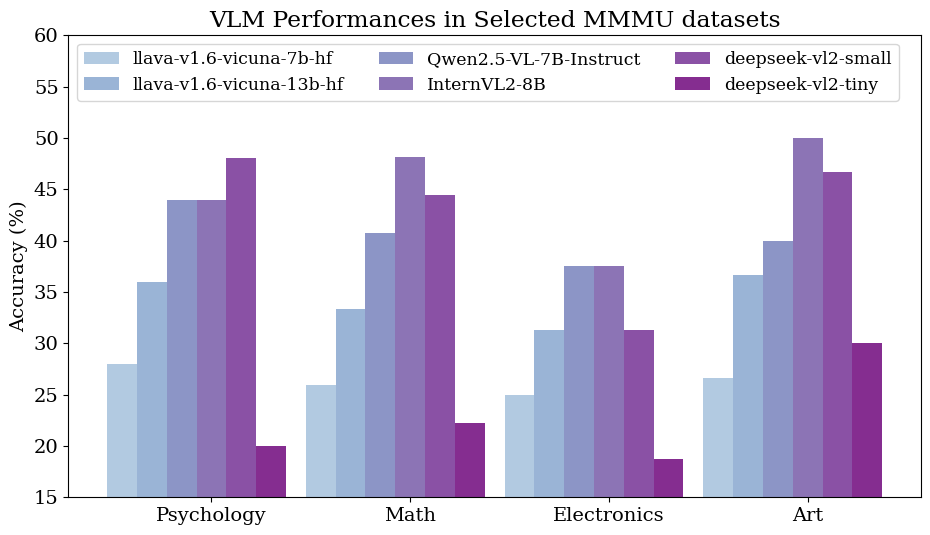

In [136]:
import matplotlib.pyplot as plt
import numpy as np

species = list(subset_scores.keys())

plt.rc("font", family="serif", size=14)

x = np.arange(len(species))# the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(11, 6))

colors = plt.cm.BuPu(np.linspace(0.3, 0.8, len(model_names)))

for k, scores in enumerate(subset_scores.values()):
    multiplier = 0
    for i, (attribute, measurement) in enumerate(scores.items()):
        offset = width * multiplier
        if k== len(species) -1:
            rects = ax.bar(x[k] + offset, measurement*100, width, color=colors[i], label=attribute)
        else:
            rects = ax.bar(x[k] + offset, measurement*100, width, color=colors[i])
        # ax.bar_label(rects, padding=3)
        multiplier += 1
        # print(attribute)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('VLM Performances in Selected MMMU datasets')
ax.set_xticks(x + 3*width, species)
ax.legend(loc='upper left', ncols=3, fontsize=12.5)
ax.set_ylim(15, 60)
plt.savefig("results/figures/bar_plot.png", dpi=200, bbox_inches="tight")

In [138]:
import pandas as pd

shorten_names = ['LLV-7b', 'LLV-13b', 'QW2.5', 'InVL2-8B', 'DS-small', 'DS-tiny']
data_df = pd.DataFrame(1-error_arr, columns=shorten_names)


In [139]:
correlation_matrix = data_df.corr()

In [140]:
correlation_matrix

,LLV-7b,LLV-13b,QW2.5,InVL2-8B,DS-small,DS-tiny
LLV-7b,1.000000,0.380862,0.240616,0.209174,0.208024,0.107521
LLV-13b,0.380862,1.000000,0.251426,0.250903,0.204263,0.157073
QW2.5,0.240616,0.251426,1.000000,0.341227,0.246484,0.177195
InVL2-8B,0.209174,0.250903,0.341227,1.000000,0.215091,0.145477
DS-small,0.208024,0.204263,0.246484,0.215091,1.000000,0.147603
DS-tiny,0.107521,0.157073,0.177195,0.145477,0.147603,1.000000


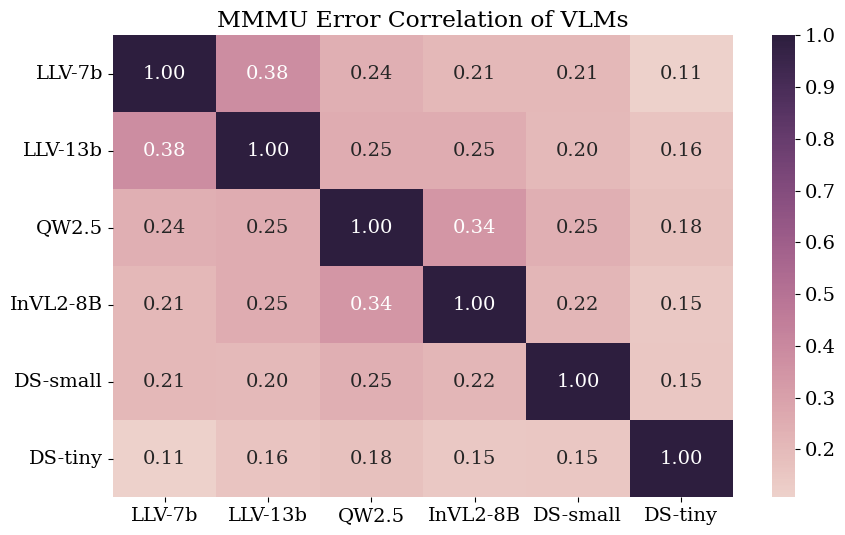

In [150]:
import seaborn as sns

plt.figure(figsize=(10, 6))  # Adjust figure size
ax = sns.heatmap(correlation_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt=".2f")
# plt.title("Correlation Matrix Heatmap")
ax.set(xlabel="", ylabel="")
# ax.xaxis.tick_top()
ax.tick_params(axis='x', rotation=0)
ax.set_title("MMMU Error Correlation of VLMs")
plt.savefig("results/figures/corr_matrix.png", dpi=200, bbox_inches="tight")

In [88]:
model_names

['llava-v1.6-vicuna-7b-hf',
 'llava-v1.6-vicuna-13b-hf',
 'Qwen2.5-VL-7B-Instruct',
 'InternVL2-8B',
 'deepseek-vl2-tiny',
 'deepseek-vl2-small']

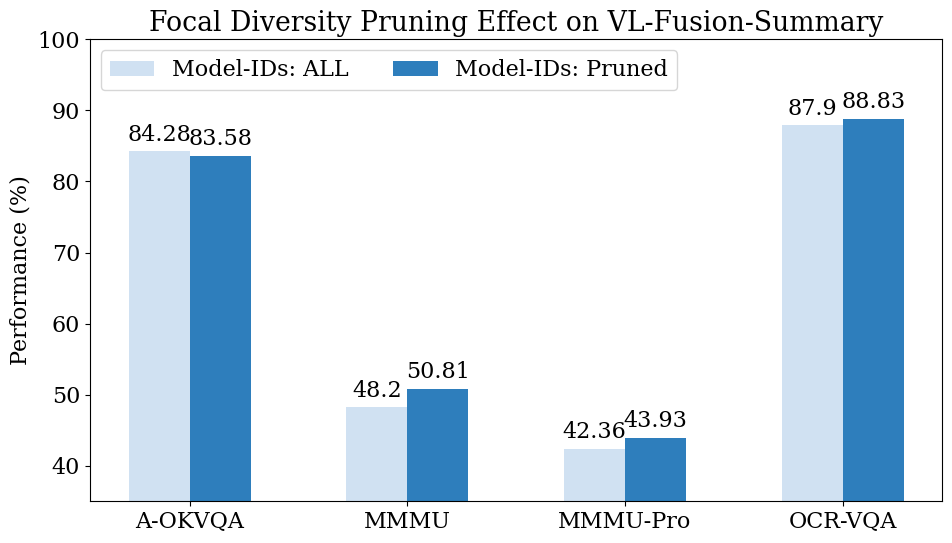

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc("font", family="serif", size=16)
mpl.rcParams['text.usetex'] = False


species = ["A-OKVQA", "MMMU", "MMMU-Pro", "OCR-VQA"]    
scores_indv = {
    "Model-IDs: ALL": [84.28, 48.2, 42.36, 87.9],
    "Model-IDs: Pruned": [83.58, 50.81, 43.93, 88.83]
}

# labels = ["Model-IDs:012345", r"Model-IDs: $234^{\*}$| $235^{\dagger}$| 123"]

x = np.arange(len(species)) # the label locations
width = 0.28  # the width of the bars
multiplier = 0

colors = plt.cm.Blues(np.linspace(0.2, 0.7, len(scores_indv)))

fig, ax = plt.subplots(figsize=(11, 6))
for i, (attribute, measurement) in enumerate(scores_indv.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, color=colors[i], label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance (%)')
ax.set_title('Focal Diversity Pruning Effect on VL-Fusion-Summary')
ax.set_xticks(x + width/2, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(35, 100)
plt.savefig("results/figures/ablation_summary.png", dpi=200, bbox_inches="tight")

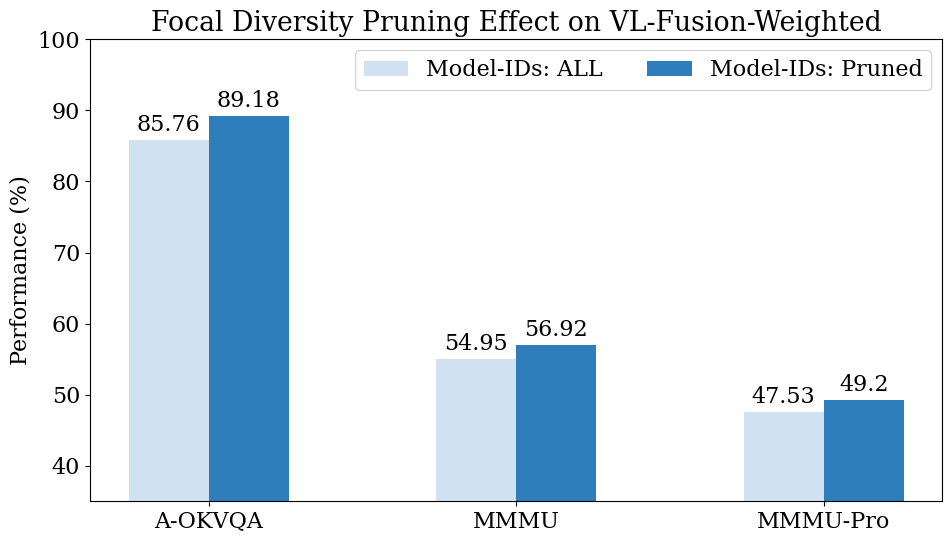

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc("font", family="serif", size=16)
mpl.rcParams['text.usetex'] = False


species = ["A-OKVQA", "MMMU", "MMMU-Pro"]    
scores_indv = {
    "Model-IDs: ALL": [85.76, 54.95, 47.53],
    "Model-IDs: Pruned": [89.18, 56.92, 49.2]
}

# labels = ["Model-IDs:012345", r"Model-IDs: $234^{\*}$| $235^{\dagger}$| 123"]

x = np.arange(len(species)) # the label locations
width = 0.26  # the width of the bars
multiplier = 0

colors = plt.cm.Blues(np.linspace(0.2, 0.7, len(scores_indv)))

fig, ax = plt.subplots(figsize=(11, 6))
for i, (attribute, measurement) in enumerate(scores_indv.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, color=colors[i], label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance (%)')
ax.set_title('Focal Diversity Pruning Effect on VL-Fusion-Weighted')
ax.set_xticks(x + width/2, species)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(35, 100)
plt.savefig("results/figures/ablation_weighted.png", dpi=200, bbox_inches="tight")

In [31]:
scores

{'llava-v1.6-vicuna-7b-hf': 0.28,
 'llava-v1.6-vicuna-13b-hf': 0.36,
 'Qwen2.5-VL-7B-Instruct': 0.44,
 'InternVL2-8B': 0.44,
 'deepseek-vl2-tiny': 0.48,
 'deepseek-vl2-small': 0.2}

In [131]:
from ens_pruning.ens_metrics import calc_div_acc

hist_data = {
    "error_arr": np.array(error_list).T,
    "pred_arr": np.array(pred_list).T,
    "label_arr": np.array(label_idx).astype(int)
}

calc_div_acc(np.array([1, 1, 1, 1, 1, 1]), hist_data)

(0.24266115116487388, 0.4956521739130435, 0.2226153106536308)

In [132]:
num_models = len(model_names)
scores = []
comb_list = []
ens_sizes = np.arange(2, num_models + 1)
for j, ens_size in enumerate(ens_sizes):
    print(ens_size)
    combinations = list(itertools.combinations(range(num_models), ens_size))
    for comb in combinations:
        comb_idx = np.zeros(num_models, dtype=int)
        comb_idx[list(comb)] = 1
        scores.append(calc_div_acc(comb_idx, hist_data))
        comb_list.append(comb_idx)
scores = np.array(scores)

2
3
4
5
6


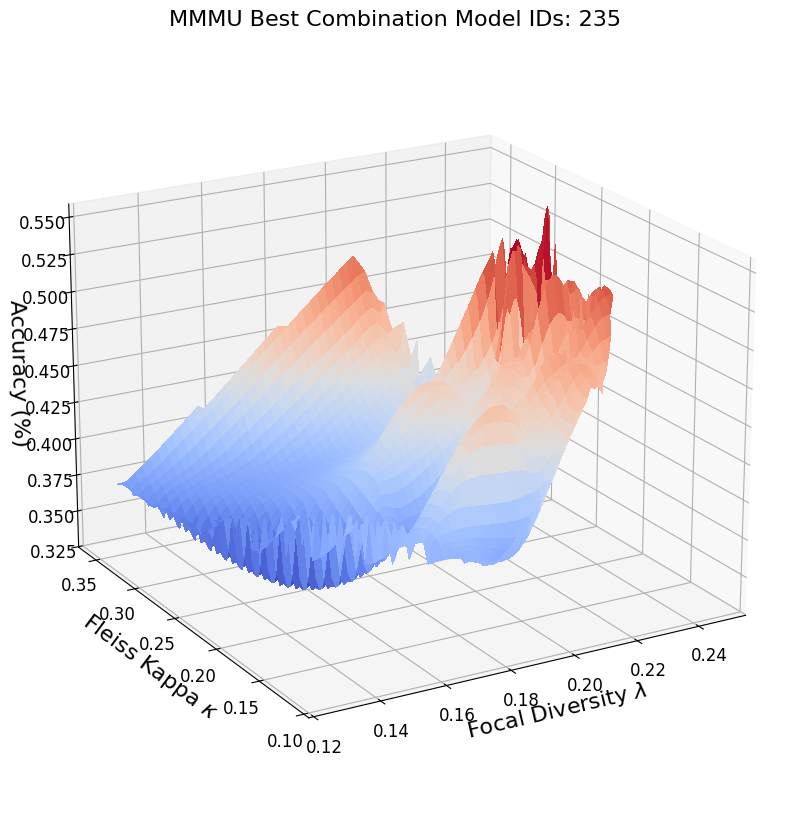

In [141]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

plt.style.use('default')

# Set global font size for all elements
plt.rcParams.update({
    'font.size': 14,              # General font size
    'axes.titlesize': 16,         # Title font size
    'axes.labelsize': 16,         # Axis label font size
    'xtick.labelsize': 12,        # X-axis tick font size
    'ytick.labelsize': 12,        # Y-axis tick font size
    'legend.fontsize': 12         # Legend font size
})

X = scores[:, 0]
Y = scores[:, 2]
Z = scores[:, 1]
xi = np.linspace(X.min(),X.max(),100)
yi = np.linspace(Y.min(),Y.max(),100)
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
xig, yig = np.meshgrid(xi, yi)
surf = ax.plot_surface(xig, yig, zi, cmap=cm.coolwarm,
                linewidth=1, antialiased=False, zorder=1)
ax.set_xlabel(r"Focal Diversity $\lambda$")
ax.set_ylabel(r"Fleiss Kappa $\kappa$")
ax.set_zlabel("Accuracy (%)")

# Customize the z axis.
# ax.set_zlim(0.30, Z.max() + 0.05)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')
idx = np.argmax(scores[:, :2].mean(1))
best_model_ids = "".join([str(j) for j in np.argwhere(comb_list[idx]).squeeze()])

ax.view_init(elev=20., azim=-120)
ax.set_title(f"{task_name.upper()} Best Combination Model IDs: {best_model_ids}")
plt.savefig(f"results/figures/{task_name}.png", bbox_inches="tight", dpi=200)

# open ended

In [156]:
import pandas as pd
import numpy as np

split = "test"
data_path = f"results/inference/ocr/{split}"

model_names = ["llava-v1.6-vicuna-7b-hf", "llava-v1.6-vicuna-13b-hf", 
               "Qwen2.5-VL-7B-Instruct", "InternVL2-8B", 
               "deepseek-vl2-tiny", "deepseek-vl2-small"]

model_outputs = []
answers = []
questions = []
error_list = []
for mn in model_names:
    data_df = pd.read_csv(f"{data_path}/{mn}_output.csv", index_col=0)
    model_outputs.append(data_df["generated_outputs"].values)
    if len(answers) == 0:
        answers = data_df["answer"].values
        questions = data_df["question"].values
    error_list.append((data_df["generated_outputs"].values == answers).astype(int))
model_outputs = np.array(model_outputs).T

In [162]:
error_arr = np.array(error_list).T

In [163]:
error_arr.shape

(3001, 6)

In [172]:
from ens_pruning.diversity_stats import calc_generalized_div


def calc_focal_div(solution, arr):
    idx = solution.astype(bool)
    set_bin_arr = arr[:, idx]
    focal_div = 0
    ens_size = sum(solution)
    for focal_idx in range(ens_size):
        focal_arr = set_bin_arr[:, focal_idx]
        neg_idx = np.where(focal_arr == 0)[0]
        neg_samp_arr = set_bin_arr[neg_idx]
        focal_div += calc_generalized_div(neg_samp_arr)
    focal_div /= ens_size


num_models = len(model_names)
scores = []
comb_list = []
ens_sizes = np.arange(2, num_models + 1)
for j, ens_size in enumerate(ens_sizes):
    print(ens_size)
    combinations = list(itertools.combinations(range(num_models), ens_size))
    for comb in combinations:
        comb_idx = np.zeros(num_models, dtype=int)
        comb_idx[list(comb)] = 1
        scores.append(calc_focal_div(comb_idx, error_arr))



2
3
4
5
6


In [173]:
scores

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [170]:
error_arr[:, comb_idx]

array([[1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]])

In [171]:
comb_idx

array([1, 1, 1, 1, 1, 1])